In [86]:
%matplotlib inline

In [87]:
import matplotlib
from matplotlib_venn import venn3_unweighted 
import pylab as plt
from matplotlib_venn import venn3, venn3_circles
from collections import OrderedDict
from matplotlib import pyplot as plt
import numpy as np

import gzip, json
import pandas as pd
import matplotlib.pyplot as plt
from collections import defaultdict as ddict
import re
import math

PREFIX = "/my-disk/linux-dev"

functions = []

with gzip.open("idle_10min.info.json.gz", mode="r") as f:
    rows_idle = json.load(f)

def func_in_idle(path):
    with gzip.open(path, mode="r") as f:
        rows = json.load(f)
    for row in rows:
        #print (row["lines"]["hit"])
        for line in row["lines"]["details"]:
            fname = row["file"]
            assert(fname.startswith(PREFIX))
            fname = fname[len(PREFIX):]
            if line["hit"] > 0:
                #for funct in functions:
                if fname not in functions:
                    functions.append(fname)
    #print (functions)
    #return hits

def compare_with_idle(fname1, hit1, line1):

     
    for row in rows_idle:
        #print (row["lines"]["hit"])
        fname2 = row["file"]
        assert(fname2.startswith(PREFIX))
        fname2 = fname2[len(PREFIX):]
        if fname1 == fname2:
            for line2 in row["lines"]["details"]:
                if line1 == line2:
                    hit2 = line2["hit"]
                    hit1 = math.ceil(hit1/10)
                    hit2 = math.ceil(hit2/10)

                    diff = hit1 - hit2
                    #iff = (hit1/600) - (hit2/600)
                    #print(hit1)
                    #print(math.ceil(hit1))
                    #print(hit2)
                    if diff > 0:
                        print (line2)
                        print (diff)
                        return True
                    else:
                        return False
                        #hits.add((fname, line["line"]))
       
    return False

def get_id(fname):
    i = 0;
    for row in rows_idle:
        fname_idle = row["file"]
        assert(fname_idle.startswith(PREFIX))
        fname_idle = fname_idle[len(PREFIX):]
        if fname_idle == fname:
            return i
        
        i = i+1
        
    return -1
    
def load_gz_to_line_sets(path):
    with gzip.open(path, mode="r") as f:
        rows = json.load(f)
    hits = set()
    i = 0
 
   # print (fname)
    #print (rows[0]["file"])
    #id = get_id(rows[0]["file"])
    #print(id)
    #print (rows_idle[id]["file"])
    for row in rows:
        fname = row["file"]
        assert(fname.startswith(PREFIX))
        fname = fname[len(PREFIX):]
        id = get_id(fname)
        row_idle = rows_idle[id]
        #print (row["lines"]["hit"])
        
        for line in row["lines"]["details"]:
            if line["hit"] > 0:
                for line_idle in row_idle["lines"]["details"]:
                    if line["line"] ==line_idle["line"]:
                        hit = math.ceil(line["hit"]/10)
                        hit_idle = math.ceil(line_idle["hit"]/10)
                        diff = hit - hit_idle
                        if(diff > 0):
                            hits.add((fname, line["line"]))
                
            #if line["hit"] > 0:
             #   hit = line["hit"]
              #  hit = hit/10
               # hits.add((fname, line["line"]))
                #if(compare_with_idle(fname, hit, line)):
                #    hits.add((fname, line["line"]))
    #print (hits)
    return hits

In [14]:
cpu_fc = load_gz_to_line_sets("fc_cpu_10min.info.json.gz")
cpu_host = load_gz_to_line_sets("host_cpu_10min.info.json.gz")
cpu_runc= load_gz_to_line_sets("runc_cpu_10min.info.json.gz")
cpu_runsc = load_gz_to_line_sets("runsc_cpu_10min.info.json.gz")
mem_host = load_gz_to_line_sets("host_mem_10min.info.json.gz")
mem_fc = load_gz_to_line_sets("fc_mem_10min.info.json.gz")
mem_runc = load_gz_to_line_sets("runc_mem_10min.info.json.gz")
mem_runsc = load_gz_to_line_sets("runsc_mem_10min.info.json.gz")
net_host = load_gz_to_line_sets("host_net_10min.info.json.gz")
net_fc = load_gz_to_line_sets("fc_net_10min.info.json.gz")
net_runc = load_gz_to_line_sets("runc_net_10min.info.json.gz")
net_runsc = load_gz_to_line_sets("runsc_net_10min.info.json.gz")
file_write_host = load_gz_to_line_sets("host_write_10min.info.json.gz")
file_write_fc =  load_gz_to_line_sets("fc_write_10min.info.json.gz") 
file_write_runc = load_gz_to_line_sets("runc_write_10min.info.json.gz")
file_write_runsc = load_gz_to_line_sets("runsc_write_10min.info.json.gz")

In [92]:


def draw_venn(filename, lines, key):
    fc = lines[(key, "fc")]
    runc = lines[(key, "runc")]
    runsc = lines[(key, "runsc")]
    sets = [fc, runc, runsc]
    v = venn3_unweighted(sets, set_labels = ('A', 'B', 'C'))
    patches = ['{0:03b}'.format(i) for i in range(1, 8)]

    def patch_count(patch):
        include = None
        exclude = set()
        for i, b in enumerate(patch):
            if int(b):
                if include == None:
                    include = sets[i]
                else:
                    include = include.intersection(sets[i])
            else:
                exclude = exclude.union(sets[i])
        return len(include - exclude)

    def mix_colors(ratio):
        low_color = (.9,.9,.9)
        high_color = (0.5,0.5,1)
        #low_color = (.9,.9,.9)
        #high_color = (.3,.3,.3)
        color = []
        for c1, c2 in zip(low_color, high_color):
            color.append(c2*ratio + c1*(1-ratio))
        return tuple(color)

    counts = [patch_count(patch) for patch in patches]
    
    for patch_id in patches:
        # determine color of patch
        if max(counts) == min(counts):
            ratio = 0
        else:
            ratio = (patch_count(patch_id) - min(counts)) / (max(counts) - min(counts))
        patch_shade = mix_colors(ratio)
        patch = v.get_patch_by_id(patch_id)
        patch.set_color(patch_shade)
        patch.set_alpha(1.0)
        patch.set_lw(1)
        patch.set_linestyle("-")
        patch.set_edgecolor("white")

    v.get_label_by_id('A').set_text('Firecracker')
    v.get_label_by_id('B').set_text('LXC')
    v.get_label_by_id('C').set_text('gVisor')
    
    t = v.get_label_by_id('A') # Firecracker text
    t.set_x(t.get_position()[0] + 0.2)
    t.set_y(t.get_position()[1] + 0.03)
    t = v.get_label_by_id('B') # LXC text
    t.set_x(t.get_position()[0] - 0.1)
    t.set_y(t.get_position()[1] + 0.03)
    t = v.get_label_by_id('C') # gVisor text
    t.set_x(t.get_position()[0] + 0.4)
    t.set_y(t.get_position()[1] + 0.15)

    bbox = matplotlib.transforms.Bbox([[1.7,0.7],[4.45,3.6]])
    matplotlib.pyplot.savefig("venn_diagrams_new/"+filename, format='eps', dpi=1200, bbox_inches=bbox)

#data = {
 #   ("k", "fc"): set("12345"),
  #  ("k", "runc"): set("16789"),
  #  ("k", "runsc"): set("1234578"),
#}
#draw_venn_v2("shaded-venn.eps", data, "k")

In [97]:
def filter_lines(line_sets, prefix):
    # KEY: (workload, system)
    # VAL: set of (file-name, line-num)
    rv = {}
    for key in line_sets:
        rv[key] = {t for t in line_sets[key] if t[0].startswith(prefix)}
    return rv

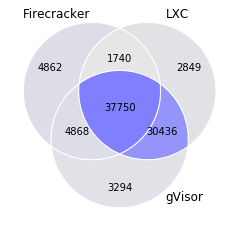

In [127]:
lines_net = {
    ("net", "fc"): net_fc,
    ("net", "runc"): net_runc,
    ("net", "runsc"): net_runsc  
}
draw_venn("net_overall_venn.eps", lines_net, "net")

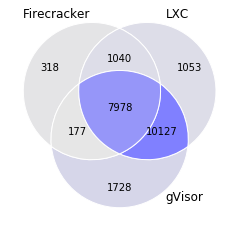

In [128]:
lines = filter_lines(lines_net, "/net")
draw_venn("net_net_venn.eps", lines, "net")

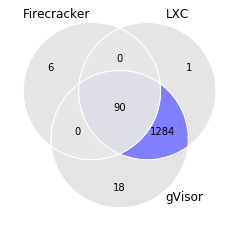

In [129]:
lines = filter_lines(lines_net, "/net/bridge")
draw_venn("net_bridge_venn.eps", lines, "net")

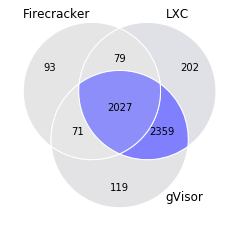

In [130]:
lines = filter_lines(lines_net, "/net/core")
draw_venn("net_core_venn.eps", lines, "net")

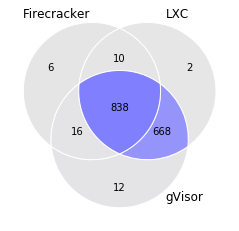

In [131]:
lines = filter_lines(lines_net, "/net/netfilter")
draw_venn("net_netfilter_venn.eps", lines, "net")

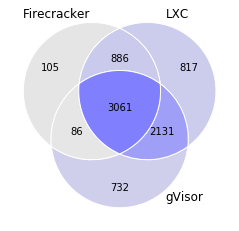

In [132]:
lines = filter_lines(lines_net, "/net/ipv4")
draw_venn("net_ipv4_venn.eps", lines, "net")

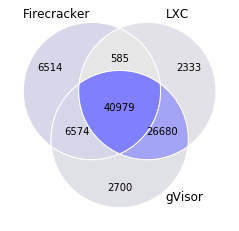

In [104]:
lines_cpu = {
    ("cpu", "fc"): cpu_fc,
    ("cpu", "runc"): cpu_runc,
    ("cpu", "runsc"): cpu_runsc
}
draw_venn("cpu_overall_venn.eps", lines_cpu, "cpu")


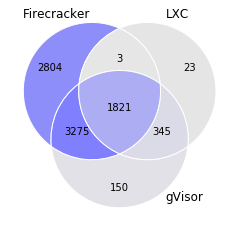

In [105]:
lines = filter_lines(lines_cpu, "/arch")
draw_venn("cpu_arch_venn.eps", lines, "cpu")

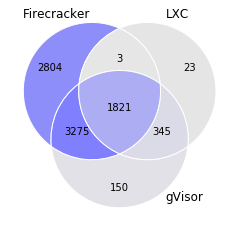

In [106]:
lines = filter_lines(lines_cpu, "/arch/x86")
draw_venn("cpu_arch_x86_venn.eps", lines, "cpu")

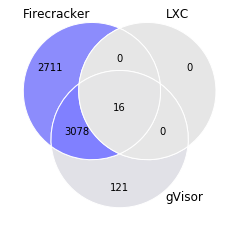

In [107]:
lines = filter_lines(lines_cpu, "/arch/x86/kvm")
draw_venn("cpu_arch_x86_kvm_venn.eps", lines, "cpu")

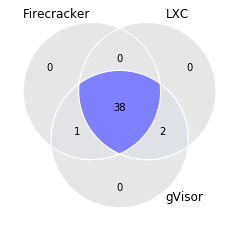

In [108]:
lines = filter_lines(lines_cpu, "/include/linux/sched")
draw_venn("cpu_include_linux_sched_venn.eps", lines, "cpu")

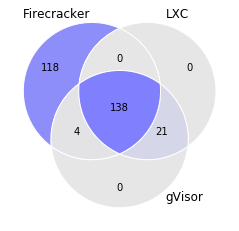

In [109]:
lines = filter_lines(lines_cpu, "/kernel/irq")
draw_venn("cpu_kernel_irq_venn.eps", lines, "cpu")

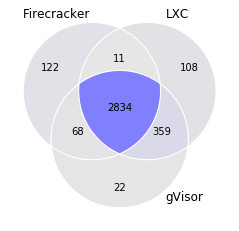

In [110]:
lines = filter_lines(lines_cpu, "/kernel/sched")
draw_venn("cpu_kernel_sched_venn.eps", lines, "cpu")

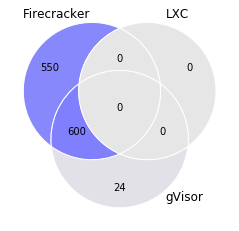

In [111]:
lines = filter_lines(lines_cpu, "/virt")
draw_venn("cpu_virt_venn.eps", lines, "cpu")

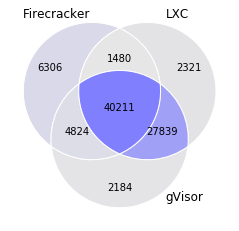

In [112]:
lines_mem = {
    ("mem", "fc"): mem_fc,
    ("mem", "runc"): mem_runc,
    ("mem", "runsc"): mem_runsc
}
draw_venn("mem_overall_venn.eps", lines_mem, "mem")

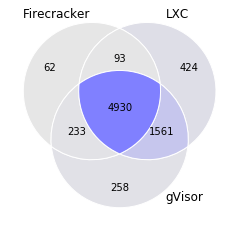

In [113]:
lines = filter_lines(lines_mem, "/mm")
draw_venn("mem_mm_venn.eps", lines, "mem")

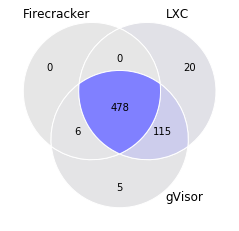

In [114]:
lines = filter_lines(lines_mem, "/arch/x86/mm")
draw_venn("mem_arch_x86_mm_venn.eps", lines, "mem")

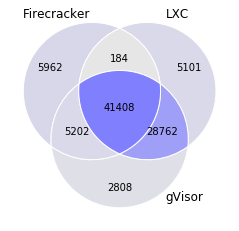

In [115]:
lines_file = {
   ("file_write", "fc"): file_write_fc,
    ("file_write", "runc"): file_write_runc,
    ("file_write", "runsc"): file_write_runsc
}
draw_venn("file_write_overall_venn.eps", lines_file, "file_write")

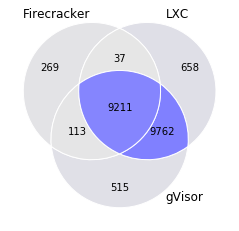

In [116]:
lines = filter_lines(lines_file, "/fs")
draw_venn("file_write_fs_venn.eps", lines, "file_write")

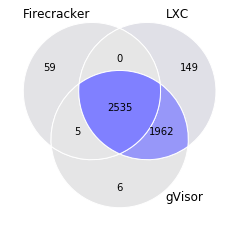

In [117]:
lines = filter_lines(lines_file, "/fs/ext4")
draw_venn("file_write_fs_ext4_venn.eps", lines, "file_write")

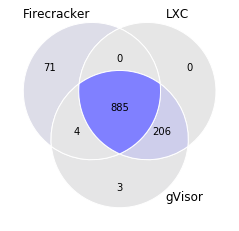

In [118]:
lines = filter_lines(lines_file, "/fs/jbd2")
draw_venn("file_write_fs_jbd2_venn.eps", lines, "file_write")

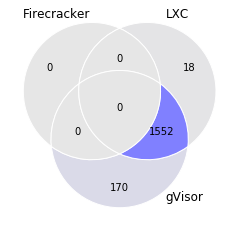

In [119]:
lines = filter_lines(lines_file, "/fs/overlayfs")
draw_venn("file_write_fs_overlayfs_venn.eps", lines, "file_write")

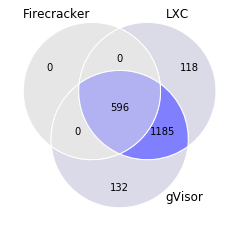

In [120]:
lines = filter_lines(lines_file, "/fs/proc")
draw_venn("file_write_fs_proc_venn.eps", lines, "file_write")